# Comparing developing vs non-developing TCs in aquaplanet simulations

In [1]:
from waveFilter import kf_filter
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats  
from functions_mpas_aqua import find_tcgen,find_tcgen_closedcontour,find_nondev_analogs_to_devtcs
import matplotlib.pyplot as plt

#increase font size
plt.rcParams.update({'font.size': 18})

#color-blind friendly colors
colors = ['#377eb8', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00'] #source: https://gist.github.com/thriveth/8560036

Define basic information that will be used to access files, filter waves, etc.

In [25]:
exp_name = 'TC_3km'
pth = "/glade/scratch/rberrios/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
# df_all = pd.read_csv("%s/VORT_vertmean_n256test/TRACK_data_all"%pth)
df_all = pd.read_csv(
    "/glade/u/home/rberrios/projects/TCgenesis_mpasaqua/data/TC_3km/TRACK_data_all_REFINED_CENTER_3km.csv")
df_all=df_all.rename(columns={'lon_pcentroid_pmin_r100':'lon','lat_pcentroid_pmin_r100':'lat'})
print(len(df_all.ID.unique()))
data_frames = list(df_all.groupby("ID"))
#tcgen_info = find_tcgen(data_frames)

# Set Pre-Defined Arguments for wave filtering
mis = -999
obsPerDay = 4
algoName='mpas'
minLat=0
maxLat=10

init_time = np.datetime64('2000-03-31 00:00:00')
obsVar = 'pr'
filtVar = obsVar
waveName = 'Kelvin'
obsPerDay = 4 #six-hourly
fname = pth+'latlon/diags_gaussian_global_nospinup_n400.nc'

labels = ['DEV','non-DEV']

# build a rectangle in axes coords
left, width = .005, .5
bottom, height = .48, .5
right = left + width
top = bottom + height

111


Identify genesis time and gather info

In [5]:
tcgen_info = find_tcgen_closedcontour(data_frames,fname,init_time)
#filter to keep equatorward of 35 N
tcgen_info = tcgen_info[tcgen_info.lat<35]

no closed contour found in MSLP
no closed contour found in MSLP
no genesis time found
no closed contour found in MSLP
no closed contour found in MSLP
no closed contour found in MSLP
no closed contour found in MSLP
no genesis time found
no genesis time found
no genesis:  102


<!-- To find non-developing analogs, let's try to find analogs at T-24 h before genesis -->

In [ ]:
# tcgen_info_minust = []
# for index, row in tcgen_info.iterrows():
    
#     df_sub = df_all[df_all.ID==row['ID']]
#     df_sub['fhr'] = df_sub['fhr']-row['fhr']
#     df_sub_minust = df_sub[df_sub.fhr==0]
#     if (not df_sub_minust.empty):
#         tcgen_info_minust.append(df_sub_minust)

# tcgen_info_minust = pd.concat(tcgen_info_minust)
# tcgen_info_minust

Find non-developing analogs to the developing TCs 

In [ ]:
# analogs_ndv,df_all = find_nondev_analogs_to_devtcs(pth+'VORT_vertmean_n256test/',tcgen_info_minust)

In [ ]:
# df_all['valid_time'] = init_time+pd.to_timedelta(df_all.fhr,unit='h')

### Basic comparison of developing and non-developing analogs

Make several plots to make sure that the analogs are truly comparable to the developing TCs.

In [ ]:
# #increase font size
# plt.rcParams.update({'font.size': 18})

# bins = np.arange(0,40,5)
# plt.figure()
# plt.hist([tcgen_info_minust.lat,analogs_ndv.lat],bins=bins,alpha=0.5)
# plt.xlabel('latitude')
# plt.ylabel('counts')
# plt.legend(labels)

In [ ]:
# #increase font size
# plt.rcParams.update({'font.size': 18})

# bins = np.arange(1,11,1)
# plt.figure()
# plt.hist([tcgen_info_minust.vor850,analogs_ndv.vor850],bins=bins,alpha=0.5)
# plt.ylabel('counts')
# plt.xlabel('600-850 hPa vorticity (10$^{-5}$ s$^{-1}$)')
# plt.legend(labels)

### Comparison of histograms w.r.t. Kelvin wave crest

Method #1: minimize a cost function

In [6]:
def filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,**kwargs):
    
    filter_info = {
        'minLat' : 0,
        'maxLat' : 10,
        'avgLat' : True
    }
    
    for keys in kwargs:
        filter_info[keys] = kwargs[keys]
    print(filter_info)
    
    #read data    
    infile = xr.open_dataset(fname)
    lon = infile.lon

    obsTime = infile.time
    nObs=len(obsTime)
    obsData = infile[obsVar].sortby('lat').sel(lat=slice(filter_info['minLat'],filter_info['maxLat']))#.mean(dim='lat')
    
    from datetime import timedelta
    # Extend filtering to 700 days
    filtTime = np.arange(0,len(obsTime)+702)

    # Incorporate original data into array
    if (filter_info['avgLat']):
        obsData = obsData.mean('lat')
        filtData=np.zeros([len(filtTime),1,len(lon)],dtype='f')
        lat = [0]
        coords = [obsTime,lon]
        dims = ['time','lon']
        filtData[0:obsData.shape[0],0,:]=obsData  
    else:
        lat = obsData.lat
        filtData=np.zeros([len(filtTime),len(lat),len(lon)],dtype='f')
        coords = [obsTime,lat,lon]
        dims = ['time','lat','lon']
        filtData[0:obsData.shape[0],:]=obsData  
    
    wave = filtData
    
    if (waveName == 'Kelvin'):
        wave_longname="Kelvin Waves in "+filtVar.upper()
        wave_filter="Straub & Kiladis (2002) to 20 days"
        wave_wavenumber=np.array([1,14],dtype='f')
        wave_period=np.array([2.5,20],dtype='f')
        wave_depth=np.array([8,90],dtype='f')
        # wave_units=unit
    elif (waveName == 'AD'):
        wave_longname="Advective Disturbances"
        wave_filter="Straub & Kiladis (2002) to 20 days"
        wave_wavenumber=np.array([-28,-4],dtype='f')
        wave_period=np.array([2.5,20],dtype='f')
        wave_depth=np.array([mis,mis],dtype='f')  
        
    #################################################
    # Filter 
    #################################################
    print("\n##############################\nFiltering %s\n"%waveName)
    for lat_counter in range(0,len(lat)):
        wave[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
                       wave_period[0],wave_period[1],\
                       wave_wavenumber[0],wave_wavenumber[1],\
                       wave_depth[0],wave_depth[1],waveName)
        
    waveData = xr.DataArray(wave[0:len(obsTime),:].squeeze(),coords=coords,dims=dims)
        
    return waveData

In [26]:
waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True)
print(waveData.std())

{'minLat': 0, 'maxLat': 10, 'avgLat': True}

##############################
Filtering Kelvin

<xarray.DataArray ()>
array(0.271693)


In [27]:
import matplotlib.path as mpath

def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)
hurricane = get_hurricane()

In [28]:
def find_closest_wave(df,waveData,waveSpd,threshold,method,init_time):
    
    tdelta = (((waveData.time[waveData.time==init_time]).squeeze()-waveData.time[0])/np.timedelta64(1, 'D')).values
    waveDatadt = waveData.differentiate('time')

    if (method=='min_cost_function'):
        time_in_hrs = np.arange(0,len(waveData.time)*6,6)/24
        [X,Y] = np.meshgrid(waveData.lon,time_in_hrs)

        waveDatadt_pos = waveDatadt.where( (waveData/waveData.std(dim='time')>=threshold) )
        print(waveData.min(),waveData.max())
        plt.figure()
        cs = plt.contour(X,Y,waveDatadt_pos,levels=[0],colors='k')
        plt.close()

        REarth = 6378.0
        zerocnt_coords = cs.allsegs

        C = 0.1*waveSpd
        days_since_wave = []
        tcs_on_peak = []
        plt.figure(figsize=(10,10))
        plt.contourf(X,Y, waveData, extend='both',
                            cmap='gist_stern_r',levels=np.linspace(0.,1.25,13))
        for i in range(0,len(df)):
            fmin = 9.9e100
            for segs in zerocnt_coords[0][:]:
                # great circle distance. 

                lat1 = np.deg2rad(10.0)
                lats = lat1
                lon1 = np.deg2rad(df.lon.iloc[i])
                lons = np.deg2rad(segs[:,0])
                arg = np.sin(lat1)*np.sin(lats)+np.cos(lat1)*np.cos(lats)*np.cos(lon1-lons)
                dx = np.arccos(arg)*REarth*1000.0
                dt = ( (df.fhr.iloc[i]+tdelta*24.0)-(segs[:,1]*24.0))*3600.0 #dt in seconds

                f = np.sqrt( (dx*dx)+(C*C*dt*dt))
                if (np.min(f) < fmin):
                    fmin = np.min(f)
                    minind = np.argmin(f)
                    minseg = segs

            plt.plot(df.lon.iloc[i],tdelta+df.fhr.iloc[i]/24.0,'k',marker=hurricane,markersize=40,mfc='none',markeredgewidth=5)
            plt.plot(minseg[:,0],minseg[:,1],c='k')
            plt.plot( [minseg[minind,0],df.lon.iloc[i]],[minseg[minind,1],(tdelta+df.fhr.iloc[i]/24.0)],'--k')

            if ( ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] >= 0.5) & \
                 ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] < 2.5)):
                tcs_on_peak.append(df.ID.iloc[i])
            days_since_wave.append( (tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1])

        print(np.min(days_since_wave),np.max(days_since_wave))
        plt.xlabel('longitude')
        plt.ylabel('days')
        plt.ylim([48,83])
        plt.savefig('example_waves+TCs.png',bbox_inches='tight')
        
        return days_since_wave,tcs_on_peak
    elif (method == 'wave_phase'):
        
        #normalize by the standard deviation
        waveData = waveData/np.std(waveData)
        waveDatadt = waveDatadt/np.std(waveDatadt)

        #define the wave phases
        phases_def = {
            '1':[-np.pi/8.0,np.pi/8.0],
            '8':[ np.pi/8.0,3.0*np.pi/8.0],
            '7':[3.0*np.pi/8.0,5.0*np.pi/8.0],
            '6':[5.0*np.pi/8.0,7.0*np.pi/8.0],
            '5':[7.0*np.pi/8.0,9.0*np.pi/8.0],
            '4':[9.0*np.pi/8.0,11.0*np.pi/8.0],
            '3':[11.0*np.pi/8.0,13.0*np.pi/8.0],
            '2':[13.0*np.pi/8.0,15.0*np.pi/8.0],
        }
        
        def nearest_date(items,pivot):
            nearest = min(items, key=lambda x: abs(x-pivot))
            timedelta = (pivot-nearest)/np.timedelta64(1, 'D')
            return nearest,timedelta

        wavePhase_tcgen = []
        waveInt_tcgen = []
        waveTen_tcgen = []
        days_since_wave = []
        waveInt_closest2tcgen = []
        dum = np.zeros(len(waveData.time))
        for i in range(0,len(df)):

            #time_of_tcgen = waveData.time[waveData.time==init_time].squeeze()+pd.to_timedelta(df.fhr.iloc[i],unit='h')
            time_of_tcgen = np.datetime64(pd.to_datetime(df.valid_time.iloc[i],format='%Y-%m-%d_%H.%M.%S'))
            #interpolate to desired longitude; extrapolate if the longitude is outside the longitude of data
            waveInt = waveData.interp(lon=df.lon.iloc[i],kwargs={"fill_value": "extrapolate"})
            waveTen = waveDatadt.interp(lon=df.lon.iloc[i],kwargs={"fill_value": "extrapolate"})

            #save the normalized wave intensity at genesis time
            waveInt_tcgen.extend(waveInt[waveInt.time==time_of_tcgen])
            waveTen_tcgen.extend(waveTen[waveInt.time==time_of_tcgen])
                        
            #obtain angle between wave intensity and tendency
            theta = xr.ufuncs.arctan2(waveTen,waveInt)
            #pivot the angle so that it ranges from -pi/8 to 15*pi./8
            theta = (theta+(2*np.pi))%(2*np.pi)
            theta[theta>=15.0*np.pi/8.0] = theta[theta>=15.0*np.pi/8.0]-2.0*np.pi
            #assign phase according to angle
            phase = xr.DataArray(dum,coords=[waveData.time],dims=['time'])
            for wp in phases_def:
                phase[(theta>=phases_def[wp][0]) & (theta<phases_def[wp][1])]=int(wp)

            #find the phase on the day of genesis
            wavePhase_tcgen.extend(phase[phase.time==time_of_tcgen])
            #find the no of days since the active wave went by the location of tcgen
        #     phase[phase==8] = -1
            active_wave = phase[(phase<=1) & ((waveInt**2.0+waveTen**2.0)**0.5 >= 1.0) ]
            
            nearest_time,dt = nearest_date(active_wave.time,waveInt.time[waveInt.time==time_of_tcgen])
            days_since_wave.append(dt)
            waveInt_closest2tcgen.extend(waveInt[waveInt.time==nearest_time])

        return days_since_wave,wavePhase_tcgen,waveInt_tcgen,waveInt_closest2tcgen

<xarray.DataArray ()>
array(-0.681947) <xarray.DataArray ()>
array(1.460374)
-9.508025612699448 17.892552702990997


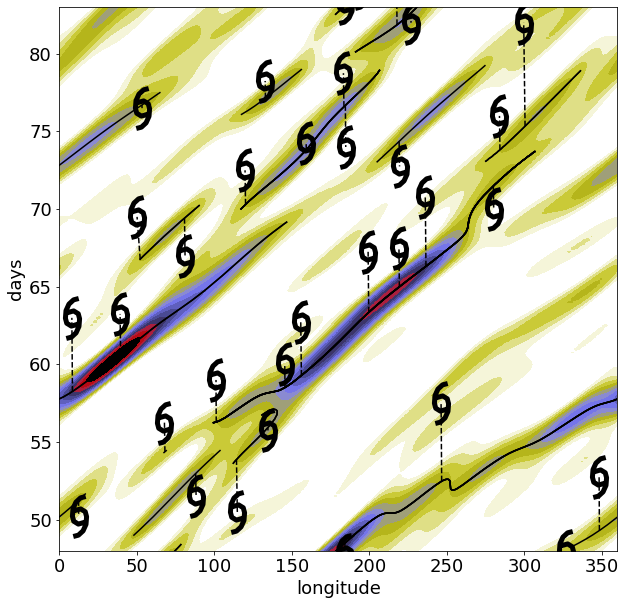

In [29]:
days_since_wave_tcs,tcs_on_peak = find_closest_wave(tcgen_info,waveData,14.5,1.0,'min_cost_function',init_time)

In [30]:
# days_since_wave_ndv,ndv_on_peak = find_closest_wave(analogs_ndv,waveData,14.5,1.0,'min_cost_function',init_time)

0.0 9.183673469387756


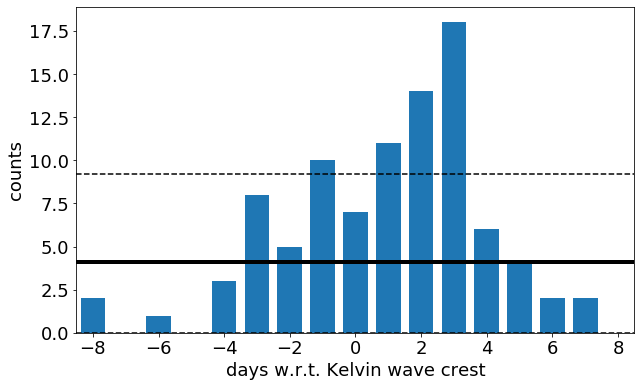

In [31]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-11.5,11.5,24)
plt.figure(figsize=(10,6))
# hist,bin_edges,patches = plt.hist([days_since_wave_tcs,days_since_wave_ndv],bins=bins)
hist,bin_edges,patches = plt.hist([days_since_wave_tcs],bins=bins,rwidth=0.75)

plt.xlabel('days w.r.t. %s wave crest'%waveName)
plt.ylabel('counts')
# labels = ['DEV (N = %i)'%len(days_since_wave_tcs),'non-DEV (N = %i)'%len(days_since_wave_ndv)]
# plt.legend(labels)
# plt.title('Method #1')
plt.xlim([-8.5,8.5])

#test for statistical significance following Schreck (2015)
# Defining model parameters
p = 1/ (len(bins)-1)
n = np.sum(hist)#[0])
k = np.linspace(0,max(hist))#[0]))
confidence = 0.99

# Generating survival function distribution and computing the number of required trials
binom = scipy.stats.binom.cdf(k, n, p)
k_025 = k[binom>=1-confidence][0]
k_975 = k[binom>=confidence][0]
print(k_025,k_975)

# Add mean and confidence intervals
plt.axhline(np.mean(hist),color='k',linewidth=4)
plt.axhline(k_025,color='k',linestyle='dashed')
plt.axhline(k_975,color='k',linestyle='dashed')

plt.savefig('histogram_DEV_wrt_%s_mincostfunc_%s.jpg'%(waveName,exp_name),bbox_inches='tight',dpi=150)

### Method #2

In [13]:
days_since_wave_tcs,wavePhase_tcgen_tcs,waveInt_tcgen_tcs,waveInt_closest_tcs = \
            find_closest_wave(tcgen_info,waveData,14.5,1.0,'wave_phase',init_time)

In [14]:
# days_since_wave_ndv,wavePhase_tcgen_ndv,waveInt_tcgen_ndv,waveInt_closest_ndv = \
#             find_closest_wave(analogs_ndv,waveData,14.5,1.0,'wave_phase',init_time)

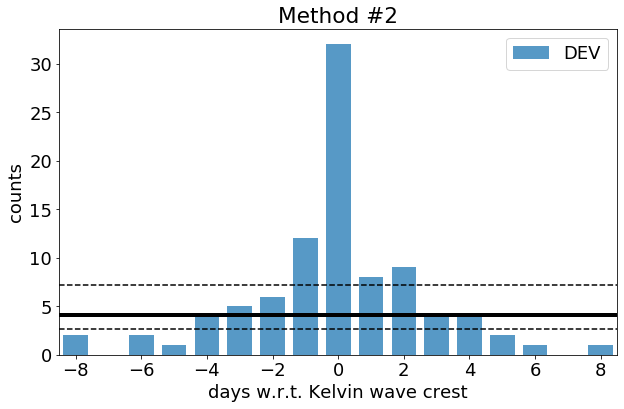

In [15]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-11.5,11.5,24)
plt.figure(figsize=(10,6))
# hist,bin_edges,patches = plt.hist([np.array(days_since_wave_tcs),np.array(days_since_wave_ndv)],bins=bins,alpha=0.75)
hist,bin_edges,patches = plt.hist(np.array(days_since_wave_tcs),bins=bins,alpha=0.75,rwidth=0.75)
plt.xlabel('days w.r.t. %s wave crest'%waveName)
plt.ylabel('counts')
plt.legend(labels)
plt.title('Method #2')
plt.xlim([-8.5,8.5])

#test for statistical significance following Schreck (2015)
# Defining model parameters
p = 1/ (len(bins)-1)
n = np.sum(hist)#[0])
k = np.linspace(0,max(hist))#[0]))
confidence = 0.9

# Generating survival function distribution and computing the number of required trials
binom = scipy.stats.binom.cdf(k, n, p)
k_025 = k[binom>=1-confidence][0]
k_975 = k[binom>=confidence][0]

# Add mean and confidence intervals
plt.axhline(np.mean(hist),color='k',linewidth=4)
plt.axhline(k_025,color='k',linestyle='dashed')
plt.axhline(k_975,color='k',linestyle='dashed')

In [16]:
# confirmed: TCs are forming from "AD" or "ER"s

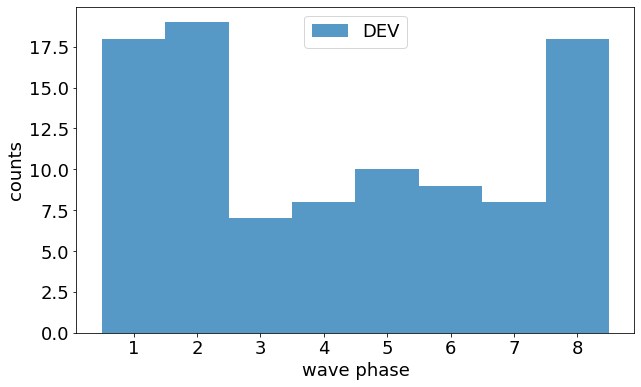

In [17]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(0.5,8.5,9)
plt.figure(figsize=(10,6))
# plt.hist([np.array(wavePhase_tcgen_tcs),np.array(wavePhase_tcgen_ndv)],bins=bins,alpha=0.75)
plt.hist(np.array(wavePhase_tcgen_tcs),bins=bins,alpha=0.75)
plt.xlabel('wave phase')
plt.ylabel('counts')
plt.legend(labels)

Text(0.5, 1.0, 'Method #2')

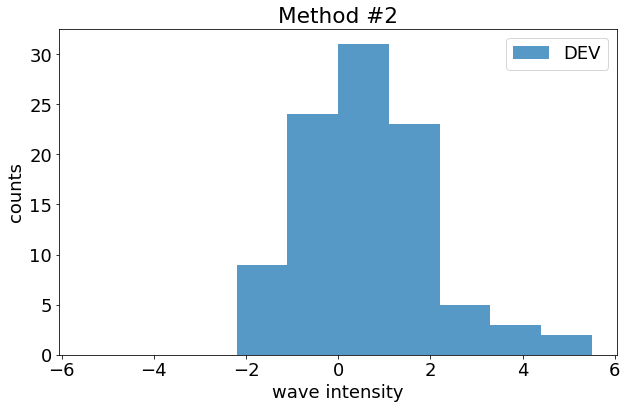

In [18]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-5.5,5.5,11)
plt.figure(figsize=(10,6))
# plt.hist([np.array(waveInt_tcgen_tcs),np.array(waveInt_tcgen_ndv)],bins=bins,alpha=0.75)
plt.hist(np.array(waveInt_tcgen_tcs),bins=bins,alpha=0.75)
plt.xlabel('wave intensity')
plt.ylabel('counts')
plt.legend(labels)
plt.title('Method #2')

# print(np.mean(waveInt_tcgen_tcs),np.mean(waveInt_tcgen_ndv))

### Plot time-series of circulation leading to cyclogenesis/analog time 
(for TCs at 0.5-3.5 days after wave peak)

In [ ]:
def get_avg_timeseries(subgroup,info):
    plt.figure()

    df_sub = df_all[df_all.ID.isin(subgroup)]
    print(len(df_sub.ID.unique()))

    out = []

    for i in df_sub.ID.unique():
        df_tc = df_sub[df_sub.ID==i]
        df_tc['fhr'] = df_tc['fhr'].values-info[info.ID==i].fhr.values
        out.append(df_tc)
        plt.plot(df_tc.fhr.values,df_tc.vor850)
    plt.xlim([-120,120])

    out = pd.concat(out)
    subgroup_avg = out.groupby('fhr').mean()
    subgroup_std = out.groupby('fhr').std()
    
    return subgroup_avg,subgroup_std

all_tcs = tcgen_info.ID.unique()
all_ndv = analogs_ndv.ID.unique()
print(len(tcs_on_peak),len(ndv_on_peak))
avg_vor_tcs,std_vor_tcs = get_avg_timeseries(tcs_on_peak,tcgen_info)
avg_vor_ndv,std_vor_ndv = get_avg_timeseries(ndv_on_peak,analogs_ndv)

plt.figure(figsize=(10,6))
plt.plot(avg_vor_tcs.index,avg_vor_tcs.vor850,linewidth=4)
plt.fill_between(avg_vor_tcs.index, avg_vor_tcs.vor850-std_vor_tcs.vor850, \
                 avg_vor_tcs.vor850+std_vor_tcs.vor850, alpha=0.25)

plt.plot(avg_vor_ndv.index,avg_vor_ndv.vor850,linewidth=4)
plt.fill_between(avg_vor_ndv.index, avg_vor_ndv.vor850-std_vor_ndv.vor850, \
                 avg_vor_ndv.vor850+std_vor_ndv.vor850, alpha=0.25)
plt.xlim([-72,72])
plt.ylim([0,7.5])
labels = ['DEV (N = %i)'%len(tcs_on_peak),'non-DEV (N = %i)'%len(ndv_on_peak)]
plt.legend(labels,loc='upper left')
plt.xlabel('time w.r.t. genesis (h)')
plt.ylabel('600$-$850 hPa vorticity (10$^{-5}$ s$^{-1}$)')

plt.vlines(0,0,avg_vor_tcs.vor850.max())

plt.savefig('timeseries_DEVvsnonDEV_vor850.jpg',bbox_inches='tight',dpi=150)

In [ ]:
df_sub = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]
df_sub.to_csv('tcgen_info_DEV.csv',index=False)
df_sub = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]
df_sub.to_csv('tcgen_info_non-DEV.csv',index=False)

### Next: center-relative hovmollers

In [ ]:
my_dict = {
    'pr': [1.0/6.0,'Blues', np.linspace(-0.02*1.5,0.34*1.5,19), 'rainfall rate anomaly (mm hr$^{-1}$)'],
    'u850': [1,'RdBu_r',np.linspace(-5,5,21),'850-hPa zonal wind anomaly (m s$^{-1}$)'],
    'v850': [1,'RdBu_r',np.linspace(-3,3,21),'850-hPa meridional wind anomaly (m s$^{-1}$)'],
    'u200': [1,'RdBu_r',np.linspace(-3,3,21),'200-hPa zonal wind anomaly (m s$^{-1}$)'],
    'precipw': [1,'BrBG',np.linspace(-5.0,5.0,21),'precipitable water anomaly (mm)'],
    'ushr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa zonal shear (m s$^{-1}$)'],
    'vshr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa meridional shear (m s$^{-1}$)'],
    'shrmag': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa shear magnitude (m s$^{-1}$)'],
    'vort850': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850-hPa relative vorticity anomaly (10$^{-5}$ s$^{-1}$)'],
    'qv500':[1000.0,'BrBG',np.linspace(-0.6,0.6,21),'500-hPa water vapor mixing ratio (g kg$^{-1}$)'],
    'rhmid':[1.0,'BrBG',np.linspace(-10.0,10.0,21),'500-700 hPa relative humidity (%)'],
    'mslp': [1.0,'viridis',np.linspace(-10,10,21),'mslp'],
    'hfx': [1.0,'RdBu_r',np.linspace(-10,10,21),'surface sensible heat flux (W m$^{-2}$)'],
    'qfx': [2.5e6,'RdBu_r',np.linspace(-20,20,21),'surface latent heat flux (W m$^{-2}$)'],
    'CI': [1.0,'RdBu_r',np.linspace(-1.25,1.25,21),'coupling index (K)'],
    'olrtoa': [1.0,'Greys',np.linspace(-50,50,21),'outgoing longwave radiation anomaly (W m$^{-2}$)'],
    'SF' : [1.0,'RdBu_r',np.linspace(-10,10,21),'total surface heat flux (W m$^{-2}$)'],
    'div200': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'200-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)'],
    'divlo': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850$-$1000-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)']
}

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 18})
def get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,**kwargs):
        
        def read_stormcentered_fields_timelon(fname,dLon,nDays,varname,df,init_time,plotting_options):
            print(plotting_options)
    
            #read netcdf file
            ds = xr.open_dataset(fname)
            #drop unnecessary variables
            ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
            dx = np.abs(ds.lon[1].values-ds.lon[0].values)
            obsTime = ds.time
            ds = ds.sortby('lat')

            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            tim_array_target = xr.DataArray(np.arange(-nDays,nDays+0.25,0.25))

            if plotting_options['subtract_zonal_time_mean']:
                time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
                ds[varname] = ds[varname] - time_zonal_mean_var

            if plotting_options['filtWaves']:
                #calling filtering function
                ds[varname] = filter_data_for_ccews(fname,varname,obsPerDay,waveName,minLat=0,maxLat=10,avgLat=False)

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                lat1 = 0.0
                lat2 = 10.0

            centered_data_0s = np.zeros( (len(df),len(tim_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    lat1 = row['lat']-10.0
                    lat2 = row['lat']+10.0

                #we'd like to save nx x ny data points, but in some cases the points may be too close to the boundarys
                tim1 = ctim-pd.to_timedelta(nDays,unit='D')
                tim2 = ctim+pd.to_timedelta(nDays,unit='D')
                lon1 = clon-dLon
                lon2 = clon+dLon

                var2tst = ds[varname].sel(time=slice(tim1,tim2),lat=slice(lat1,lat2))
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2))

                #subtract zonal and time mean
                var_intrp = var_intrp

                #transform time relative to genesis time
                var_intrp['time'] = (var_intrp.time-ctim)/np.timedelta64(1,'D')

                tim_rel = tim_array_target.where( (tim_array_target>=var_intrp.time.min()) & (tim_array_target<=var_intrp.time.max()) )
                ds_out[d,tim_rel.argmin().values:tim_rel.argmax().values+1,:] = var_intrp.mean(dim='lat')

    #             plt.figure()
    #             plt.contourf(ds_out[d,:,:])
    #             plt.title(row['ID'])
    #             break
                d += 1
        
            return ds_out,lon_array_target,tim_array_target
        

        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'subtract_zonal_time_mean' : True,
            'overlay' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
        
        fig, ax = plt.subplots(figsize=(12,8))

        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]


            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname1,df,init_time,plotting_options_var1)
            centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname2,df,init_time,plotting_options_var2)
            centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
            [X,Y] = np.meshgrid(lon,time)

            cf = ax.contourf(X,Y,centered_data_avg1,extend='both',cmap=my_dict[varname][1], 
                          levels=my_dict[varname1][2])#,norm=norm,cmap=cmap)
            cl = ax.contour(X,Y,centered_data_avg2,colors='m',linewidth=4,levels=[0.1,0.2,0.3,0.4,0.5])
            
        else:
            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname,df,init_time,plotting_options)
            centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
            print(centered_data_avg.min(),centered_data_avg.max())
            [X,Y] = np.meshgrid(lon,time)

            cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varname][1], 
                          levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
            cl = ax.contour(X,Y,centered_data_avg,levels=[0.],colors='k',linestyles='dashed')
    
#     with open('test_%s_%s.npy'%(exps[n],varname), 'wb') as f:
#         np.save(f,centered_data_avg)
        
        ax.set_xlabel('longitude w.r.t. cyclogenesis')
        ax.set_ylabel('days w.r.t. cyclogenesis')
        plt.hlines(0,-dLon,dLon)
        plt.vlines(0,-nDays,nDays)
        ax.grid(True)
    
        cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
        cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
        cbar.set_label(my_dict[varname][3])
        fig.tight_layout(pad=0.1)
        plt.savefig(varname+'_wrt_cyclogenesis_%s.png'%exp_name,bbox_inches='tight')

### Developers

In [ ]:
dLon=35.1
nDays=10
lat_option='eq'
df = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]

In [ ]:
# varname = 'pr'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option='eq',varname2='pr',
#                                filtWaves_var2=True,subtract_zonal_time_mean_var2=False,overlay=True)

In [ ]:
# varname = 'pr'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option,filtWaves='True',subtract_zonal_time_mean=False)

In [ ]:
# varname = 'u850'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
# varname = 'v850'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
# varname = 'precipw'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

### Non-developers

In [ ]:
df = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]

In [ ]:
# varname = 'pr'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option='eq',varname2='pr',
#                                filtWaves_var2=True,subtract_zonal_time_mean_var2=False,overlay=True)

In [ ]:
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option,filtWaves='True',subtract_zonal_time_mean=False)

In [ ]:
# varname = 'u850'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
# varname = 'precipw'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

Hypothesis: ${\color{red} {\text{strong, broad}}}$ Kelvin waves </font> are the ones that help w/ TC genesis!!! </font> 

Can be tested with maps...

### Horizontal maps

In [ ]:
def gcdist(lon1,lons,lat1,lats):
        lon1 = np.radians(lon1)
        lons = np.radians(lons)
        lat1 = np.radians(lat1)
        lats = np.radians(lats)
        # great circle distance. 
        arg = np.sin(lat1)*np.sin(lats)+np.cos(lat1)*np.cos(lats)*np.cos(lon1-lons)
        
        # Ellipsoid [CLARKE 1866]  Semi-Major Axis (Equatorial Radius)
        a = 6378.2064
        return np.arccos(arg)* a        

In [ ]:
def get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,**kwargs):

        def read_stormcentered_fields_latlon(ds,dLon,dLat,nDays,varname,df,init_time,plotting_options):
                        
            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat','lon'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    clat = row['lat']

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc    
                        
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:,:] = var_intrp

                if (plot_individual_tcs):
                    plt.figure()
                    plt.contourf(ds_out[d,:,:])
                    plt.title(row['ID'])

                d += 1
            print('total no. tcs in composite: %i'%d)
            return ds_out,lon_array_target,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname)
        obsTime = ds.time

        #drop unnecessary variables
        keep_vars = ['time','lat','lon',varname]
        
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        obsTime = ds.time
        ds = ds.sortby('lat')
            
        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]
                    
            #subtract mean or filter for each wave
            if plotting_options_var1['subtract_zonal_time_mean']:
                time_zonal_mean_var = ds[varname1].mean(dim=('time','lon'))
                ds[varname1] = ds[varname1] - time_zonal_mean_var

            if plotting_options_var2['filtWaves']:
                #calling filtering function
                ds[varname2] = filter_data_for_ccews(fname,varname2,obsPerDay,waveName,minLat=-5,maxLat=15,avgLat=False)
            
        for lag in nDays:

            fig, ax = plt.subplots(figsize=(16,4))
            
            if (plotting_options['overlay']):
                                
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname1,df,init_time,plotting_options_var1)
                centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname2,df,init_time,plotting_options_var2)
                centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
                print(centered_data_avg1.min(),centered_data_avg1.max())
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg1,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg2,colors='k',levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
                
            else:
                
                if plotting_options['subtract_zonal_time_mean']:
                    time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
                    ds[varname] = ds[varname] - time_zonal_mean_var

                if plotting_options['filtWaves']:
                    #calling filtering function
                    ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=plotting_options['clat']-dLat,maxLat=plotting_options['clat']+dLat,avgLat=False)
                    
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname,df,init_time,plotting_options)
                centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
                print(centered_data_avg.min(),centered_data_avg.max())
            
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg,levels=[0.],colors='k',linestyles='dashed')
                
            ax.set_xlabel('longitude w.r.t. cyclogenesis')
            ax.set_ylabel('latitude')
    #        plt.hlines(0,-dLon,dLon)
            plt.vlines(0,np.min(lat),np.max(lat))
            ax.grid(True)
            plt.title('t = %i days'%lag)

            cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
            cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
            cbar.set_label(my_dict[varname][3])
            fig.tight_layout(pad=0.1)
            
            #add panel labels
            plt.text(left, top, '%s (N = %i)'%(TCgroup,len(df)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='18', bbox=dict(facecolor='white'))
        
            plt.savefig('%s_latlon_%s_%s_%sdays.jpg'%(varname,exp_name,TCgroup,lag),bbox_inches='tight',dpi=150)

In [ ]:
dLat = 35.1/4.0
dLon = 35.1
varname = 'pr'
plot_individual_tcs = False
lat_option = 'eq'
df = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]
print(len(tcs_on_peak))

# #lag=np.arange(-10,3,1)
# nDays = [-2]
# get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,filtWaves=True,subtract_zonal_time_mean=False)

In [ ]:
nDays = [-5,-3,-2,-1,0,1,2]
varname = 'u850'
TCgroup = 'DEV'
get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,clat=dLat/2,
                        filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
                        filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

In [ ]:
df = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]
TCgroup = 'non-DEV'
print(len(ndv_on_peak))

In [ ]:
nDays = [-5,-4,-3,-2,-1,0,1,2]
varname = 'u850'
get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,clat=dLat/2,
                        filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
                        filtWaves_var2=True,subtract_zonal_time_mean_var2=False)

--To do-- 
(1) incorporate option to have 2 variables with contour colors and contour lines in plotting functions, (2) add function that plots zonally averaged profiles (to check for barotropic instability)

In [ ]:
def get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,**kwargs):
    
        def read_stormcentered_zonally_avg_fields(ds,dLon,dLat,nDays,varname,df,init_time,plotting_options):
            
            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    clat = row['lat']

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
   
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc                     
                
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:] = var_intrp.mean(dim='lon')

                if (plot_individual_tcs):
                    plt.figure()
                    plt.plot(ds_out[d,:])
                    plt.title(row['ID'])

                d += 1

            print('total no. tcs in composite: %i'%d)
            return ds_out,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname)
        obsTime = ds.time
        
        if (varname == 'SF'):
            ds[varname] = ds.hfx + ds.qfx*2.5e6

        #drop unnecessary variables
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        obsTime = ds.time
        ds = ds.sortby('lat')
        
        if ('vor' in varname):
            ds[varname] = ds[varname] + (2.0*7.292e-5)*xr.ufuncs.sin(xr.ufuncs.radians(ds.lat))
            
        if plotting_options['subtract_zonal_time_mean']:
            time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
            ds[varname] = ds[varname] - time_zonal_mean_var

        if plotting_options['filtWaves']:
            #calling filtering function
            ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=0,maxLat=33,avgLat=False)
            
        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]
            
        for lag in nDays:

            fig, ax = plt.subplots(figsize=(6,8))
            
            if (plotting_options['overlay']):
                centered_data,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname1,df,init_time,plotting_options_var1)
                centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
                centered_data,lat = rread_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname2,df,init_time,plotting_options_var2)
                centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                cf = ax.plot(centered_data_avg1,lat)
                cl = ax.plot(centered_data_avg2,lat,colors='k',levels=[0.1,0.2,0.3,0.4])
                
            else:
                centered_data1,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname,df1,init_time,plotting_options)
                centered_data_avg1 = centered_data1.mean(dim='ID')*my_dict[varname][0]

                centered_data2,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname,df2,init_time,plotting_options)
                centered_data_avg2 = centered_data2.mean(dim='ID')*my_dict[varname][0]
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                
                ax.plot(centered_data_avg1,lat,linewidth=4)
                ax.plot(centered_data_avg2,lat,linewidth=4)
                
            ax.set_ylabel('latitude')
            ax.set_xlabel('850-hPa absolute vorticity \n anomaly (10$^{-5}$ s$^{-1}$)')#my_dict[varname][3])
#             plt.hlines(0,-dLon,dLon)
            plt.vlines(0,np.min(lat),np.max(lat))
            ax.grid(True)
            plt.title('t = $%i$ days'%lag)
            labels = ['DEV (N = %i)'%len(df1),'non-DEV (N = %i)'%len(df2)]
            plt.legend(labels)
#             plt.xlim([-1,1])

            fig.tight_layout(pad=0.1)
            plt.savefig('%s_profiles_%s_DEVvsnon-DEV_%sdays.jpg'%(varname,exp_name,lag),bbox_inches='tight',dpi=150)

In [ ]:
dLat = 35.1/4.0
dLon = 35.1#21.06
plot_individual_tcs = False
lat_option = 'eq'
df1 = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]
df2 = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]
len(tcs_on_peak)

In [ ]:
nDays=[-1,0,1]
varname='vort850'
get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,
                                           lat_option=lat_option,subtract_zonal_time_mean=True,
                                           TC_removal=True,clat=dLat/2)

In [ ]:
###needed: repeat this analysis w/ ALL vortices removed as in Davis et al (2008)

In [ ]:
get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,
                                           lat_option=lat_option,subtract_zonal_time_mean=False,
                                           TC_removal=False,clat=dLat/2)